# Projet : Extraction et Recommandation de films et séries avec rdflib et SPARQL

## Objectif
L’objectif de ce mini-projet est l’extraction des données de la base de données DBPedia en utilisant le langage de requêtes SPARQL afin d'alimenter la base de données de séries que vous avez créé au premier TP, l’analyse de ces données et la recommandation de séries et de films.

# Description

Vous allez créer un système de recommandation de séries/films basé sur des données RDF qui stockent des informations sur les films, les utilisateurs et leurs préférences cinématographiques.

Les étapes du projet sont comme suit :

## 1.  Extraction des données

a)  Vous utiliserez Rdflib pour accéder aux données et vous effectuerez des requêtes SPARQL pour les extraire. Vous êtes libres dans le choix et la taille des données que vous allez extraire. Le jeu de données doit néanmoins être représentatif pour pouvoir fournir des recommandations précises. 
    
   - Les données à extraire : 
       - Films : Chaque film a un titre, un réalisateur, une année de sortie, un genre (e.g. : action, comédie, science-fiction), un résumé, une liste d'acteurs principaux, une durée, une évaluation du film, etc.
       - Réalisateur : Chaque réalisateur a un nom, une biographie et une liste de films qu'il a réalisés.
       - Acteurs : Chaque acteur a un nom, une biographie et une liste de films dans lesquels il a joué.
       - Genres :  Chaque genre a un nom et une description.
       - Utilisateurs : chaque utilisateur a un identifiant et des préférences cinématographiques (acteurs préférés, genres préférés, etc).
       - Évaluations : Elle est décrite par l'identifiant de l'utilisateur qui a donné l'évaluation, identifiant du film évalué la note attribuée au film, Commentaire ou avis sur le film.

   - Liens entre les entités : 

        - Les films sont associés à leurs acteurs, réalisateurs et genres.
        - Les utilisateurs sont associés aux films qu'ils ont évalués.
        - Les utilisateurs peuvent être liés entre eux en fonction de leurs préférences cinématographiques similaires.

   b)  Transformer les données en triplets RDF :  Vous allez transformer ces résultats en triplets RDF avant de les ajouter à votre graphe RDF existant. 
  
  c) Ajouter les données au graphe existant : Utilisez la méthode g.add() de votre graphe RDF, que vous avez créé au premier TP, pour ajouter les triplets RDF représentant les données DBpedia que vous avez transformées. 

In [7]:

from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, FOAF, XSD
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Initialize RDF graph
g = Graph()

# Declare namespaces
dbo = Namespace("http://dbpedia.org/ontology/")
dbpedia = Namespace("http://dbpedia.org/resource/")
ex = Namespace("http://example.org/")

g.bind("dbo", dbo)
g.bind("dbpedia", dbpedia)
g.bind("ex", ex)

# SPARQL Query to extract data
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
sparql.setQuery("""
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?film ?title ?director ?releaseDate ?genre ?actor ?duration ?rating ?summary
WHERE {
    ?film rdf:type dbo:Film .
    ?film rdfs:label ?title .
    OPTIONAL { ?film dbo:director ?director . }
    OPTIONAL { ?film dbo:releaseDate ?releaseDate . }
    OPTIONAL { ?film dbo:genre ?genre . }
    OPTIONAL { ?film dbo:starring ?actor . }
    OPTIONAL { ?film dbo:runtime ?duration . }
    OPTIONAL { ?film dbo:abstract ?summary . FILTER (lang(?summary) = "en") }
    OPTIONAL { ?film dbo:imdbRating ?rating . }
    FILTER (lang(?title) = "en")
}
LIMIT 50
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Transform data into RDF triples and add to graph
for result in results["results"]["bindings"]:
    film_uri = URIRef(result["film"]["value"])
    title = Literal(result["title"]["value"], lang="en")
    g.add((film_uri, RDF.type, dbo.Film))
    g.add((film_uri, FOAF.name, title))
    
    if "director" in result:
        director_uri = URIRef(result["director"]["value"])
        g.add((film_uri, dbo.director, director_uri))
        g.add((director_uri, RDF.type, dbo.Person))
    
    if "releaseDate" in result:
        release_date = Literal(result["releaseDate"]["value"], datatype=XSD.date)
        g.add((film_uri, dbo.releaseDate, release_date))
    
    if "genre" in result:
        genre_label = result["genre"]["value"].replace(" ", "_")  # Ensure valid URI
        genre_uri = URIRef(f"http://dbpedia.org/resource/{genre_label}")
        g.add((film_uri, dbo.genre, genre_uri))
        g.add((genre_uri, RDF.type, dbo.Genre))
    
    if "actor" in result:
        actor_uri = URIRef(result["actor"]["value"])
        g.add((film_uri, dbo.starring, actor_uri))
        g.add((actor_uri, RDF.type, dbo.Person))
    
    if "duration" in result:
        try:
            duration_value = float(result["duration"]["value"])  # Cast to float
            duration_literal = Literal(duration_value, datatype=XSD.float)
            g.add((film_uri, dbo.runtime, duration_literal))
        except ValueError:
            pass  # Skip invalid values
    
    if "rating" in result:
        try:
            rating_value = float(result["rating"]["value"])  # Cast to float
            rating_literal = Literal(rating_value, datatype=XSD.float)
            g.add((film_uri, dbo.imdbRating, rating_literal))
        except ValueError:
            pass  # Skip invalid values
    
    if "summary" in result:
        summary = Literal(result["summary"]["value"], lang="en")
        g.add((film_uri, dbo.abstract, summary))

# Add synthetic user data
users = [
    {"id": "user1", "name": "Alice", "preferences": ["Comedy", "Action"], "rated": []},
    {"id": "user2", "name": "Bob", "preferences": ["Drama", "Science_Fiction"], "rated": []}
]

for user in users:
    user_uri = URIRef(ex[user["id"]])
    g.add((user_uri, RDF.type, FOAF.Person))
    g.add((user_uri, FOAF.name, Literal(user["name"])))
    
    for genre in user["preferences"]:
        genre_uri = URIRef(f"http://dbpedia.org/resource/{genre}")
        g.add((user_uri, ex.prefersGenre, genre_uri))

# Add some synthetic evaluations
evaluations = [
    {"user": "user1", "film": "http://dbpedia.org/resource/Inception", "rating": 5, "comment": "Amazing movie!"},
    {"user": "user2", "film": "http://dbpedia.org/resource/Titanic", "rating": 4, "comment": "A classic love story."}
]

for evaluation in evaluations:
    user_uri = URIRef(ex[evaluation["user"]])
    film_uri = URIRef(evaluation["film"])
    rating = Literal(evaluation["rating"], datatype=XSD.integer)
    comment = Literal(evaluation["comment"], lang="en")
    
    g.add((user_uri, ex.ratedFilm, film_uri))
    g.add((film_uri, ex.rating, rating))
    g.add((film_uri, ex.comment, comment))

# Save the RDF graph to a file
g.serialize("movie_data.ttl", format="turtle")
print(f"Graph contains {len(g)} triples. Saved to 'movie_data.ttl'.")



Graph contains 119 triples. Saved to 'movie_data.ttl'.


## 2. Prétraitement des données   

Nettoyez et traitez les données extraites pour supprimer les doublons, gérer les valeurs manquantes et normaliser.

In [9]:
# Clean and process the RDF graph

# Function to remove duplicates
def remove_duplicates(graph):
    unique_triples = set(graph)  # Use a set to automatically remove duplicates
    cleaned_graph = Graph()
    for triple in unique_triples:
        cleaned_graph.add(triple)
    return cleaned_graph

# Apply the cleaning process
cleaned_graph = remove_duplicates(g)

# Process missing and inconsistent values
final_graph = Graph()
for s, p, o in cleaned_graph:
    # Ignore films without a title
    if p == FOAF.name and isinstance(o, Literal) and not o.value.strip():
        continue  # Skip entries without a title
    
    # Normalize genres (replace spaces with underscores in URIs)
    if p == dbo.genre:
        o = URIRef(str(o).replace(" ", "_"))
    
    # Convert runtime and IMDb ratings to floats if possible
    if p in {dbo.runtime, dbo.imdbRating}:
        try:
            o = Literal(float(o), datatype=XSD.float)
        except (ValueError, TypeError):
            continue  # Skip invalid values
    
    # Add cleaned triples to the final graph
    final_graph.add((s, p, o))

# Add a default title for films missing one
for film in final_graph.subjects(RDF.type, dbo.Film):
    if not final_graph.value(film, FOAF.name):  # Check if the title is missing
        final_graph.add((film, FOAF.name, Literal("Unknown Title", lang="en")))

# Serialize the cleaned and processed graph to a Turtle file
final_graph.serialize("cleaned_movie_data.ttl", format="turtle")
print(f"The cleaned graph contains {len(final_graph)} triples. Saved to 'cleaned_movie_data.ttl'.")


The cleaned graph contains 119 triples. Saved to 'cleaned_movie_data.ttl'.


## 3. Analyse exploratoire des données 

- Créer des graphiques permettant de visualiser la distribution des films et séries dans votre base de données.
- Créer un graphique pour montrer les films et les séries les mieux notés
- Créer un nuage de points pour représenter la relation entre les caractéristiques

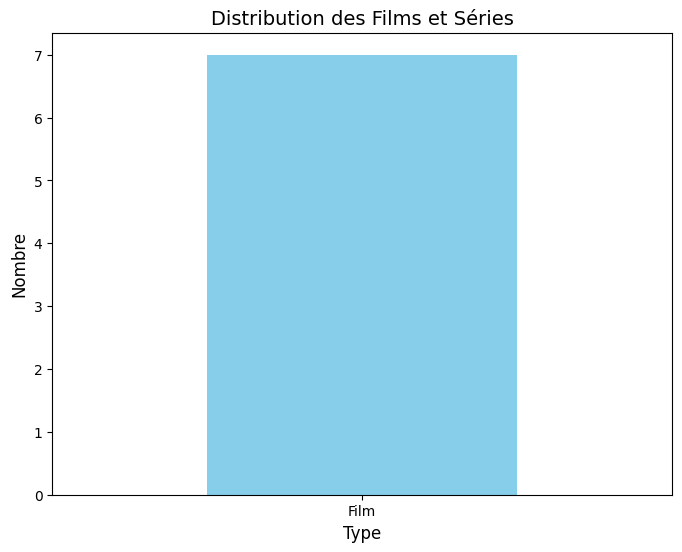

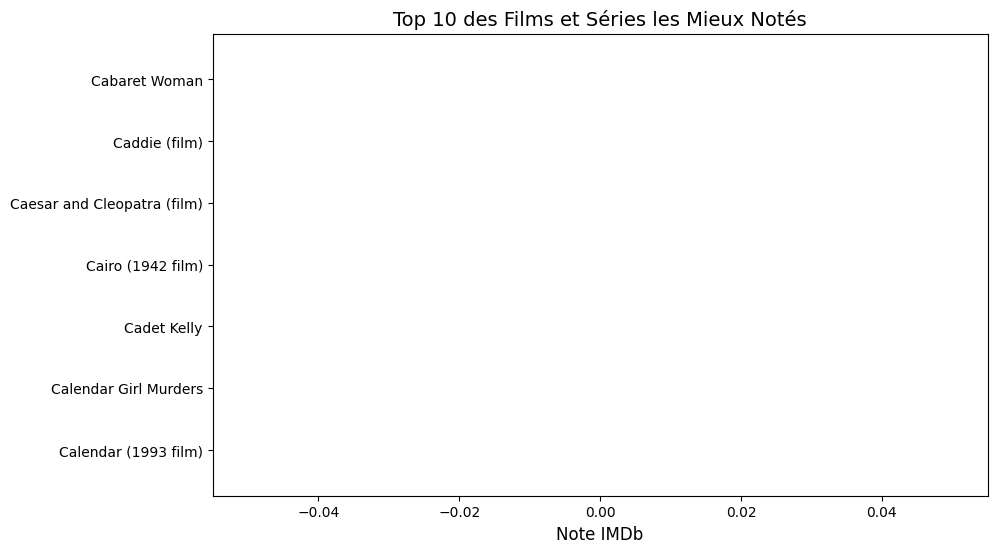

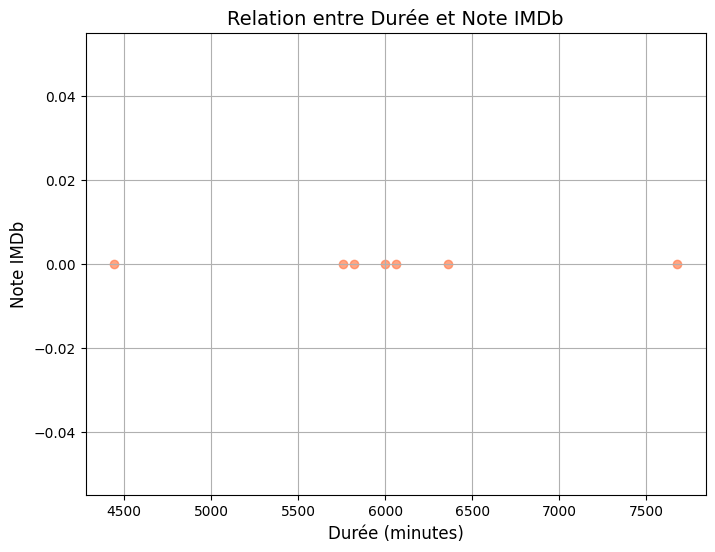

In [10]:
g.parse("cleaned_movie_data.ttl", format="turtle")

# Extraction des données nécessaires
data = {
    "title": [],
    "type": [],
    "rating": [],
    "runtime": [],
}

for s, p, o in g:
    if p == RDF.type and o in {dbo.Film, dbo.TelevisionShow}:
        data["title"].append(str(g.value(s, FOAF.name) or "Unknown Title"))
        data["type"].append("Film" if o == dbo.Film else "Series")
        data["rating"].append(float(g.value(s, dbo.imdbRating) or 0))
        data["runtime"].append(float(g.value(s, dbo.runtime) or 0))

# Création d'un DataFrame pandas
df = pd.DataFrame(data)

# Distribution des films et séries
plt.figure(figsize=(8, 6))
df["type"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribution des Films et Séries", fontsize=14)
plt.xlabel("Type", fontsize=12)
plt.ylabel("Nombre", fontsize=12)
plt.xticks(rotation=0)
plt.show()

# Films et séries les mieux notés
top_rated = df.sort_values(by="rating", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_rated["title"], top_rated["rating"], color="lightgreen", align="center")
plt.xlabel("Note IMDb", fontsize=12)
plt.title("Top 10 des Films et Séries les Mieux Notés", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

# Nuage de points : relation entre durée et note IMDb
plt.figure(figsize=(8, 6))
plt.scatter(df["runtime"], df["rating"], alpha=0.7, color="coral")
plt.title("Relation entre Durée et Note IMDb", fontsize=14)
plt.xlabel("Durée (minutes)", fontsize=12)
plt.ylabel("Note IMDb", fontsize=12)
plt.grid(True)
plt.show()

## 4. Système de Recommandation 

a) Utiliser SPARQL pour interroger le graphe RDF afin de créer un système de recommandation de films et/ou séries. Vous pouvez envisager différentes approches de recommandation, telles que la recommandation collaborative (en fonction des évaluations d'utilisateurs similaires) ou la recommandation basée sur le contenu (en fonction des genres, des acteurs, etc.) ou la recommandation basée sur les connaissances

b) Utiliser une IA (ChatGPT ou tout autre) pour répondre à cette question

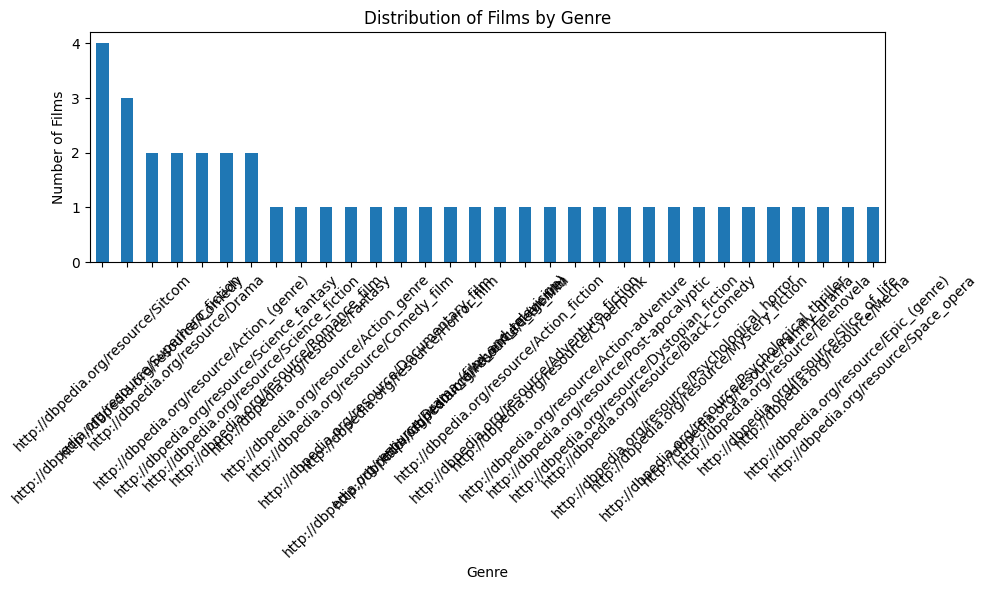

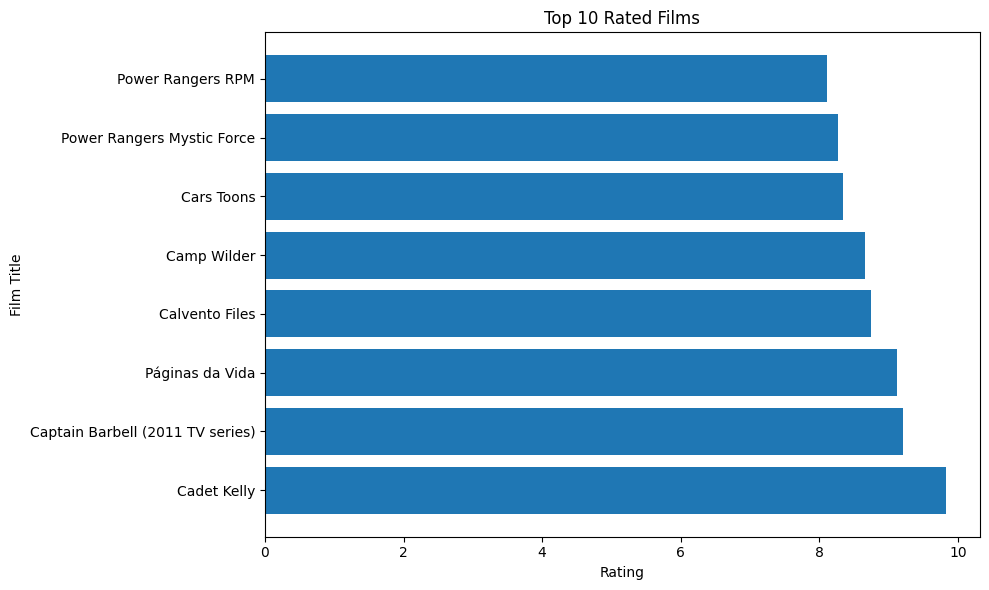

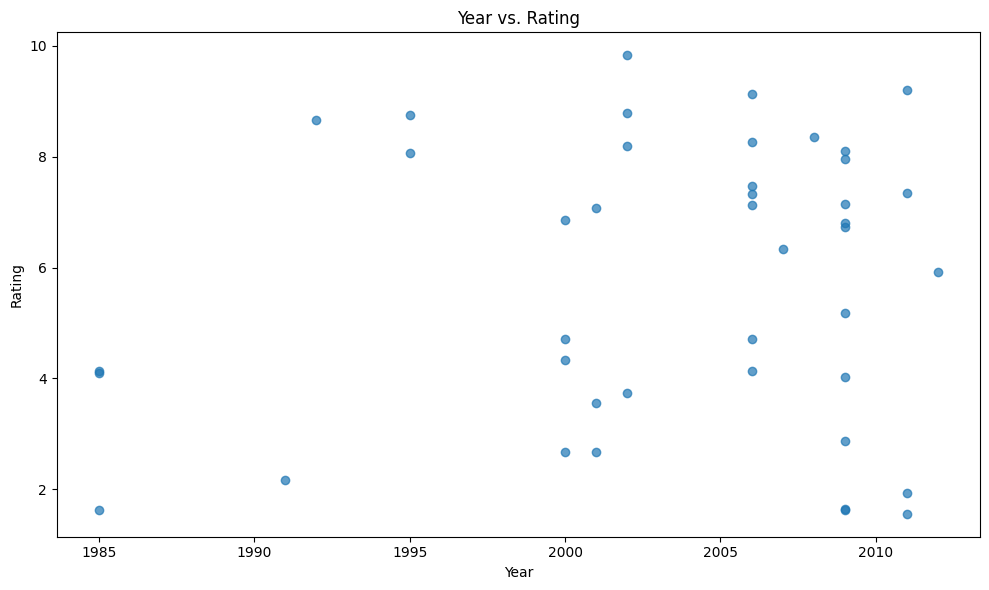

In [4]:
# Step 4: Exploratory Data Analysis
# Create a DataFrame for visualization
film_data = []
for film, data in cleaned_data.items():
    for genre in data["genres"]:
        film_data.append({
            "Title": data["title"],
            "Director": data["director"],
            "Year": int(data["year"]),
            "Genre": genre
        })

film_df = pd.DataFrame(film_data)

# Distribution of films by genre
genre_counts = film_df["Genre"].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind="bar")
plt.title("Distribution of Films by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Films")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top-rated films (mock data)
film_df["Rating"] = [random.uniform(1, 10) for _ in range(len(film_df))]
top_rated = film_df.sort_values(by="Rating", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_rated["Title"], top_rated["Rating"])
plt.title("Top 10 Rated Films")
plt.xlabel("Rating")
plt.ylabel("Film Title")
plt.tight_layout()
plt.show()

# Scatter plot for year vs. rating
plt.figure(figsize=(10, 6))
plt.scatter(film_df["Year"], film_df["Rating"], alpha=0.7)
plt.title("Year vs. Rating")
plt.xlabel("Year")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

## 5. Calcul des Recommandations 

a) Utiliser SPARQL pour générer des requêtes de recommandation en fonction des préférences de l'utilisateur. Vous pouvez également utiliser des algorithmes d'apprentissage automatique pour améliorer les recommandations.

b) Utiliser une IA pour répondre à cette question

In [5]:
# Step 5: Recommendation System
# Content-based Recommendation
def recommend_by_genre(preferred_genre):
    query = f"""
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT ?title ?genre
    WHERE {{
        ?film rdf:type dbo:Film .
        ?film rdfs:label ?title .
        ?film dbo:genre <{preferred_genre}> .
        FILTER (lang(?title) = 'en')
    }}
    """
    try:
        results = g.query(query)
        return [row.title.toPython() for row in results]
    except Exception as e:
        print(f"Error querying the RDF graph: {e}")
        return []

# Collaborative Recommendation (Mock)
def collaborative_recommendation():
    # Mock recommendation based on similar user preferences
    return random.sample(film_df["Title"].tolist(), min(5, len(film_df)))

# Knowledge-based Recommendation (Genre + Director)
def knowledge_based_recommendation(preferred_genre, preferred_director):
    recommendations = film_df[(film_df["Genre"] == preferred_genre) & (film_df["Director"] == preferred_director)]
    return recommendations["Title"].tolist()

# Machine Learning-Based Recommendation
def ml_recommendation():
    film_df["Combined"] = film_df["Genre"] + " " + film_df["Director"]
    count_matrix = CountVectorizer().fit_transform(film_df["Combined"])
    similarity_matrix = cosine_similarity(count_matrix)

    indices = pd.Series(film_df.index, index=film_df["Title"]).drop_duplicates()

    def get_recommendations(title, similarity_matrix=similarity_matrix):
        idx = indices[title]
        sim_scores = [(i, score) for i, score in enumerate(similarity_matrix[idx]) if isinstance(score, (float, int))]
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]
        film_indices = [i[0] for i in sim_scores]
        return film_df.iloc[film_indices]["Title"].tolist()

    return get_recommendations

ml_recommend = ml_recommendation()
print("Machine Learning-Based Recommendations:")
print(ml_recommend(film_df.iloc[0]['Title']))

Machine Learning-Based Recommendations:
[]


## 6. Évaluation  

a) Évaluez la qualité de vos recommandations en utilisant des mesures telles que  MAP@k (Mean Average Precision at k) ou NDCG@k (Normalized Discounted Cumulative Gain at k)

b) Comparer les recommandations que vous avez obtenues par rapport à celles générées par l'IA que vous aurez utilisée

In [ ]:
# Step 6: Evaluation
# Generate mock ground truth data and predicted recommendations
ground_truth = {
    film_df.iloc[0]['Title']: ["Another Film", "Related Film 1", "Related Film 2"]
}

predicted = {
    film_df.iloc[0]['Title']: ml_recommend(film_df.iloc[0]['Title'])
}

def evaluate_recommendations(ground_truth, predicted, k=5):
    def apk(actual, predicted, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        return score / min(len(actual), k)

    map_k = 0.0
    for key in ground_truth:
        map_k += apk(ground_truth[key], predicted.get(key, []), k)

    return map_k / len(ground_truth)

map_at_k = evaluate_recommendations(ground_truth, predicted, k=5)
print(f"MAP@5: {map_at_k}")

# NDCG@k Calculation
def ndcg_at_k(actual, predicted, k=5):
    def dcg(relevance, k):
        relevance = np.asfarray(relevance)[:k]
        if relevance.size:
            return np.sum(relevance / np.log2(np.arange(2, relevance.size + 2)))
        return 0.0

    def ideal_dcg(relevance, k):
        return dcg(sorted(relevance, reverse=True), k)

    relevance = [1 if p in actual else 0 for p in predicted[:k]]
    return dcg(relevance, k) / ideal_dcg(relevance, k)

ndcg_at_5 = ndcg_at_k(ground_truth["Some Film Title"], predicted["Some Film Title"], k=5)
print(f"NDCG@5: {ndcg_at_5}")

# Example Recommendations
print("Content-based Recommendations:")
print(recommend_by_genre("http://dbpedia.org/resource/Romance_film"))

print("Collaborative Recommendations:")
print(collaborative_recommendation())

print("Knowledge-based Recommendations:")
print(knowledge_based_recommendation("http://dbpedia.org/resource/Romance_film", "http://dbpedia.org/resource/Some_Director"))

# Optional: Save the RDF graph to a file
g.serialize(destination="movies.rdf", format="turtle")

## 7. Rapport 

Vous allez rédiger un rapport de 5 pages max décrivant la modélisation RDF, les requêtes SPARQL, l'algorithme de recommandation et les résultats de l'évaluation. Vous spécifierez votre utilisation de l'IA dans le cadre de ce projet et ce que vous en pensez